# Building a Food Vision Model

## Checking our GPU, Importing Libraries, and Loading Dataset

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-420b2bf3-ae5a-6a70-739c-6c9048235aea)


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-26 14:48:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-26 14:48:31 (135 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteVODH4I/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteVODH4I/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Understanding our Data

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = ds_info.features["label"].names

In [9]:
train_one_sample = train_data.take(1)

In [10]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image dtype: {image.dtype},
  Target clas: {label},
  Class name : {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image dtype: <dtype: 'uint8'>,
  Target clas: 72,
  Class name : pancakes
  


In [11]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'pancakes')

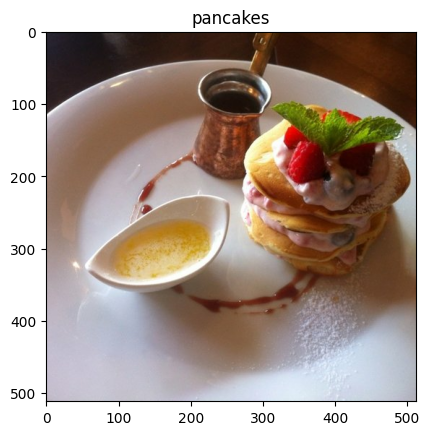

In [12]:
plt.imshow(image)
plt.title(class_names[label.numpy()])


##Creating Preprocessing Function


In [13]:
def preprocess_img(img, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image img to [img_shape, img_shape, color_channels]
  """
  img = tf.image.resize(img,[img_shape,img_shape])
  return tf.cast(img, tf.float32), label

In [14]:
pre_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]},\nShape:{image.shape},\n Datatype: {image.dtype}")
print(f"Image after preprocessing:\n{pre_img[:2]},\nShape:{pre_img.shape},\n Datatype: {pre_img.dtype}")

Image before preprocessing:
 [[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]],
Shape:(512, 512, 3),
 Datatype: <dtype: 'uint8'>
Image after preprocessing:
[[[41.127552  39.127552  50.127552 ]
  [40.642857  38.642857  49.642857 ]
  [40.285713  38.285713  49.285713 ]
  ...
  [48.92855   21.928549   4.500022 ]
  [47.7398    20.7398     3.7398005]
  [49.301044  22.301043   5.3010426]]

 [[40.642857  38.642857  49.642857 ]
  [42.9949    40.9949    51.9949   ]
  [41.85714   39.85714   50.85714  ]
  ...
  [49.127533  22.127531   4.699003 ]
  [47.862247  20.862246   3.8622465]
  [48.928574  21.928572   4.9285717]]],
Shape:(224, 224, 3),
 Datatype: <dtype: 'float32'>


## Batching and Preparing Data


In [15]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

In [16]:
import os
checkpoint_path = "model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      verbose=1)

## Mixed Precision Setup

In [17]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


In [18]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Building Our Feature Extraction Model

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [20]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)

], name = "data_aug")

In [21]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = layers.Input(shape=input_shape, name ="input_layer")
#x = data_augmentation(inputs)
x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name ="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])





16705208/16705208 [==============================] - 2s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [23]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Fit our model

In [24]:
history_101 = model.fit(train_data,
                        epochs = 5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps = int(0.15*(len(test_data)))
                        )

Epoch 1/5
2368/2368 [==============================] - 204s 79ms/step - loss: 1.7154 - accuracy: 0.5816 - val_loss: 1.1253 - val_accuracy: 0.6970
Epoch 2/5
2368/2368 [==============================] - 183s 76ms/step - loss: 1.1991 - accuracy: 0.6902 - val_loss: 1.0342 - val_accuracy: 0.7172
Epoch 3/5
2368/2368 [==============================] - 187s 78ms/step - loss: 1.0545 - accuracy: 0.7244 - val_loss: 0.9868 - val_accuracy: 0.7254
Epoch 4/5
2368/2368 [==============================] - 182s 76ms/step - loss: 0.9587 - accuracy: 0.7479 - val_loss: 0.9698 - val_accuracy: 0.7360
Epoch 5/5
2368/2368 [==============================] - 184s 77ms/step - loss: 0.8877 - accuracy: 0.7658 - val_loss: 0.9507 - val_accuracy: 0.7368


In [25]:
results = model.evaluate(test_data)

790/790 [==============================] - 56s 70ms/step - loss: 0.9695 - accuracy: 0.7360


In [26]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.set_weights(model.get_weights())

cloned_model.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00025),
                metrics=["accuracy"])




In [27]:
cloned_model.evaluate(test_data)

790/790 [==============================] - 58s 70ms/step - loss: 0.9695 - accuracy: 0.7360


[0.9694662690162659, 0.7360395789146423]

In [28]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.5, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)

In [30]:
for layer in cloned_model.layers:
    layer.trainable=True

## Fine Tuning

In [31]:


#for layer in base_model.layers[:-10]:
 # layer.trainable=False





history_fine_aug = cloned_model.fit(train_data,
                             epochs= 5,
                             steps_per_epoch = len(train_data),
                             validation_data = test_data,
                             validation_steps = int(0.15*len(test_data)),
                             callbacks = [early_stopping,
                                          reduce_lr]

                            )


Epoch 1/5
2368/2368 [==============================] - 205s 83ms/step - loss: 0.7682 - accuracy: 0.8030 - val_loss: 0.9443 - val_accuracy: 0.7415 - lr: 2.5000e-04
Epoch 2/5
2368/2368 [==============================] - 183s 76ms/step - loss: 0.7496 - accuracy: 0.8088 - val_loss: 0.9296 - val_accuracy: 0.7444 - lr: 2.5000e-04
Epoch 3/5
2368/2368 [==============================] - 186s 78ms/step - loss: 0.7360 - accuracy: 0.8133 - val_loss: 0.9373 - val_accuracy: 0.7447 - lr: 2.5000e-04
Epoch 4/5
2368/2368 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.8168
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2368/2368 [==============================] - 181s 76ms/step - loss: 0.7239 - accuracy: 0.8168 - val_loss: 0.9432 - val_accuracy: 0.7402 - lr: 2.5000e-04
Epoch 5/5
2368/2368 [==============================] - 184s 77ms/step - loss: 0.7004 - accuracy: 0.8249 - val_loss: 0.9399 - val_accuracy: 0.7434 - lr: 1.2500e-04
